In [251]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
import random
from itertools import combinations


In [252]:
def mapear_valor(x):
    mapeo = {"ENTAILMENT": 1, "NEUTRAL": 2, "CONTRADICTION":0}
    return mapeo.get(x, x)  # Si no está en el mapeo, devuelve el original


In [253]:
def convertirLabel(l):
    new_l=[]
    for a in l: 
        if (type(a)==type("a")):
            if a.upper() in ["ENTAILMENT","ENTAILMENT,","ENTAILS",'PROBABLE ENTAILMENT', 'PROBABLY ENTAILMENT']:
                new_l.append(1)
            elif a.upper() in ["NEUTRAL","NEUTRAL,"] :
                new_l.append(2)
            elif a.upper() in ["CONTRADICTION","CONTRADICTION,","CONTRADITION","CONTRADCTION","NOT_ENTAILMENT","NOT ENTAILMENT"]:
                new_l.append(0)
            else:
                new_l.append(9)    
        else:
            new_l.append(9)
    return new_l

In [254]:
def convertir(l):
    new_l=[]
    for a in l:
        if (type(a)==type("a")):
            if a.upper() in ["ENTAILMENT","ENTAILMENT,","ENTAILS",'PROBABLE ENTAILMENT', 'PROBABLY ENTAILMENT']:
                new_l.append("ENTAILMENT")
            elif a.upper() in ["NEUTRAL","NEUTRAL,"] :
                new_l.append("NEUTRAL")
            elif a.upper() in ["CONTRADICTION","CONTRADICTION,","CONTRADITION","CONTRADCTION","NOT_ENTAILMENT","NOT ENTAILMENT"]:
                new_l.append("CONTRADICTION")
            else:
                new_l.append(9)    
        else:
            new_l.append(9)
    return new_l

# obtener votos y voto majority promedios del modelo

In [ ]:
datasets = ["SNLI","SICK"]
models=["gemma2","gemma2:2b","llama3.1","llama3.2","phi3:medium","phi3"]

In [256]:
#combinations for G1,G2,G3,G4 -> three and two for scenarios failure
grupos=["G1","G2","G3","G4"]
combinationsGs = list(combinations(grupos, 3))
combinationsGs.extend(list(combinations(grupos, 2)))

In [ ]:
n_samples = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
labels=set()
for m in models:
    for d in datasets:
        print("Model",m,"dataset",d)
        corpus=d.lower()
        ruta=m+"/"+d+"/complete/"
        salida=m+"/"+d+"/answers/"
        data_g="../data/samples/"+d+"/"
        dt_data={'cv':[],'DT':[],'root':[],'deep':[],'parameters':[]}
        for i in range(5): # CV
            random.seed(i)
            samples_random = random.sample(n_samples, 10)
            n_train = set(n_samples).difference(set(samples_random))
            #print(samples_random,n_train)

            #TRAIN
            for j in n_train:
                new_data = {}

                lista_respuestas_G1 = pd.read_pickle(ruta+"rit_"+str(j)+"_G1.pickle")["Answer"].to_list()
                lista_respuestas_G2 = pd.read_pickle(ruta+"rit_"+str(j)+"_G2.pickle")["Answer"].to_list()
                lista_respuestas_G3 = pd.read_pickle(ruta+"rit_"+str(j)+"_G3.pickle")["Answer"].to_list()
                lista_respuestas_G4 = pd.read_pickle(ruta+"rit_"+str(j)+"_G4.pickle")["Answer"].to_list()
                y_true = pd.read_pickle(data_g+corpus+str(j)+".pickle")["gold_label"].to_list()
                y_true = convertir(y_true)

                new_data["G1"]=convertir(lista_respuestas_G1)
                new_data["G2"]=convertir(lista_respuestas_G2)
                new_data["G3"]=convertir(lista_respuestas_G3)
                new_data["G4"]=convertir(lista_respuestas_G4)
                new_data["gold_label"]=y_true
                
                new_data = pd.DataFrame(new_data)
                
                labels=labels.union(set(lista_respuestas_G1))
                labels=labels.union(set(lista_respuestas_G2))
                labels=labels.union(set(lista_respuestas_G3))
                labels=labels.union(set(lista_respuestas_G4))
                #Checar aciertos para cada grupo
                #aciertos
                v_a_G1=[]
                v_a_G2=[]
                v_a_G3=[]
                v_a_G4=[]
                v_a_ST=[]
                        
                for index,strings in new_data.iterrows():
                    if str(strings["G1"]).upper()==str(strings["gold_label"]).upper():
                        v_a_G1.append(1)
                    else:
                        v_a_G1.append(0)
                    if str(strings["G2"]).upper()==str(strings["gold_label"]).upper():
                        v_a_G2.append(1)
                    else:
                        v_a_G2.append(0)
                    if str(strings["G3"]).upper()==str(strings["gold_label"]).upper():
                        v_a_G3.append(1)
                    else:
                        v_a_G3.append(0)
                    if str(strings["G4"]).upper()==str(strings["gold_label"]).upper():
                        v_a_G4.append(1)
                    else:
                        v_a_G4.append(0)

                # probar sobre la aportación de cada grupo
                new_data["G1_aciertos"]=v_a_G1
                new_data["G2_aciertos"]=v_a_G2
                new_data["G3_aciertos"]=v_a_G3
                new_data["G4_aciertos"]=v_a_G4
                
                new_data.to_pickle(salida+"cv"+str(i+1)+"/w_answers_s"+str(j)+".pickle")

            
            # GS_DT
            
            ln_train = list(n_train)

            for k in range(len(ln_train)):
                if k==0:
                    dataset_train=pd.read_pickle(salida+"cv"+str(i+1)+"/w_answers_s"+str(ln_train[k])+".pickle")
                else:
                    tempdata=pd.read_pickle(salida+"cv"+str(i+1)+"/w_answers_s"+str(ln_train[k])+".pickle")
                    dataset_train=pd.concat([dataset_train,tempdata],axis=0)
            dataset_train=dataset_train.reset_index(drop=True)

            data_X=dataset_train[["G1","G2","G3","G4"]].map(mapear_valor)
            data_Y=dataset_train["gold_label"].map(mapear_valor).values
            
            clf = DecisionTreeClassifier(random_state=i)
            clf.fit(data_X, data_Y)
            
            #save parameters of DT

            dt_data["cv"].append(i+1)
            dt_data["DT"].append("SKA_DT")
            dt_data["root"].append("G"+str(clf.feature_importances_.argmax()+1))
            dt_data["deep"].append(clf.get_depth())
            dt_data["parameters"].append(clf.get_params())
            
            # GS_DT combinatios three and two of G1,G2,G3,G4
            DT_comb_GS=[]
            ln_train = list(n_train)

            for comb in combinationsGs:
                if len(comb)==3:
                    data_X=dataset_train[[comb[0],comb[1],comb[2]]].map(mapear_valor)
                elif len(comb)==2:
                    data_X=dataset_train[[comb[0],comb[1]]].map(mapear_valor)
                clf_gs = DecisionTreeClassifier(random_state=i)
                clf_gs.fit(data_X, data_Y)
                dt_data["cv"].append(i+1)
                #save parameters of DT
                dt_data["DT"].append(comb)
                dt_data["root"].append("G"+str(clf.feature_importances_.argmax()+1))
                dt_data["deep"].append(clf.get_depth())
                dt_data["parameters"].append(clf.get_params())
                DT_comb_GS.append(clf_gs)

            # Weighted VM (weights)
            new_data_pesos={"sample":[],"alpha_G1":[],"alpha_G2":[],"alpha_G3":[],"alpha_G4":[],"sumaT":[]}
            for k in n_train:
                df = pd.read_pickle(salida+"cv"+str(i+1)+"/w_answers_s"+str(k)+".pickle")
                alpG1=1
                alpG2=1
                alpG3=1
                alpG4=1
                alpST=1
                for index,strings in df.iterrows():
                    conteosE=0
                    if strings["G1_aciertos"]==0:
                        conteosE+=1
                    if strings["G2_aciertos"]==0:
                        conteosE+=1
                    if strings["G3_aciertos"]==0:
                        conteosE+=1
                    if strings["G4_aciertos"]==0:
                        conteosE+=1
                    #print(conteosE)
                    if strings["G1_aciertos"]==1:
                        alpG1+=conteosE/4
                    if strings["G2_aciertos"]==1:
                        alpG2+=conteosE/4
                    if strings["G3_aciertos"]==1:
                        alpG3+=conteosE/4
                    if strings["G4_aciertos"]==1:
                        alpG4+=conteosE/4
                alpG1=np.round(alpG1,0)
                alpG2=np.round(alpG2,0)
                alpG3=np.round(alpG3,0)
                alpG4=np.round(alpG4,0)
                sumaT=alpG1+alpG2+alpG3+alpG4
                new_data_pesos["sample"].append(k)
                new_data_pesos["alpha_G1"].append(alpG1)
                new_data_pesos["alpha_G2"].append(alpG2)
                new_data_pesos["alpha_G3"].append(alpG3)
                new_data_pesos["alpha_G4"].append(alpG4)
                new_data_pesos["sumaT"].append(sumaT)

            new_data_pesos=pd.DataFrame(new_data_pesos)
            new_data_pesos.to_pickle(salida+"cv"+str(i+1)+"/alphas_4gs.pickle")
            pesos=new_data_pesos.mean().values[1:]

            # get results 
            new_dataR = {'group':[],'sample':[],'accuracy':[], 'matriz_confusion':[],
                'Contra_precision':[], 'Contra_recall':[], 'Contra_f1':[], 
                'Neutral_precision':[], 'Neutral_recall':[], 'Neutral_f1':[], 
                'Entail_precision':[], 'Entail_recall':[], 'Entail_f1':[],#'errores':[],'errores_sustituidos':[],
                'CEntailment':[],'CNeutral':[],'CContradiction':[],
                'G1_IVM':[],'G2_IVM':[],'G3_IVM':[],'G4_IVM':[]}

            for j in samples_random:
                new_data = {}

                lista_respuestas_Base = pd.read_pickle(ruta+"rit_Base_"+str(j)+".pickle")["Answer"].to_list()
                lista_respuestas_AoT = pd.read_pickle(ruta+"ritB_AoT"+str(j)+".pickle")["Answer"].to_list()
                lista_respuestas_SAoT = pd.read_pickle(ruta+"ritB_SAoT"+str(j)+".pickle")["Answer"].to_list()
                lista_respuestas_SAoT_FS = pd.read_pickle(ruta+"ritB_SAoT_FS"+str(j)+".pickle")["Answer"].to_list()
                lista_respuestas_DR = pd.read_pickle(ruta+"rit_"+str(j)+"_DR_4r.pickle")["Answer"].to_list()
                lista_respuestas_G1 = pd.read_pickle(ruta+"rit_"+str(j)+"_G1.pickle")["Answer"].to_list()
                lista_respuestas_G2 = pd.read_pickle(ruta+"rit_"+str(j)+"_G2.pickle")["Answer"].to_list()
                lista_respuestas_G3 = pd.read_pickle(ruta+"rit_"+str(j)+"_G3.pickle")["Answer"].to_list()
                lista_respuestas_G4 = pd.read_pickle(ruta+"rit_"+str(j)+"_G4.pickle")["Answer"].to_list()
                y_true = pd.read_pickle(data_g+corpus+str(j)+".pickle")["gold_label"].to_list()
                y_true = convertir(y_true)

                new_data["Base"]=convertir(lista_respuestas_Base)
                new_data["AoT"]=convertir(lista_respuestas_AoT)
                new_data["SAoT"]=convertir(lista_respuestas_SAoT)
                new_data["SAoT_FS"]=convertir(lista_respuestas_SAoT_FS)
                new_data["DR"]=convertir(lista_respuestas_DR)
                new_data["G1"]=convertir(lista_respuestas_G1)
                new_data["G2"]=convertir(lista_respuestas_G2)
                new_data["G3"]=convertir(lista_respuestas_G3)
                new_data["G4"]=convertir(lista_respuestas_G4)
                new_data["gold_label"]=y_true
                
                new_data = pd.DataFrame(new_data)
                
                # label predict
                labels=labels.union(set(lista_respuestas_Base))
                labels=labels.union(set(lista_respuestas_AoT))
                labels=labels.union(set(lista_respuestas_SAoT))
                labels=labels.union(set(lista_respuestas_SAoT_FS))
                labels=labels.union(set(lista_respuestas_G1))
                labels=labels.union(set(lista_respuestas_G2))
                labels=labels.union(set(lista_respuestas_G3))
                labels=labels.union(set(lista_respuestas_G4))

                #SKA_DT

                X_test=new_data[["G1","G2","G3","G4"]].map(mapear_valor)
                y_gold=new_data["gold_label"].map(mapear_valor).values

                y_pred=[]
                for a in clf.predict(X_test):
                    y_pred.append(a)
                
                eti=[]
                for kas in y_pred:
                    if(kas==1):
                        eti.append("ENTAILMENT")
                    elif(kas==0):
                        eti.append("CONTRADICTION")
                    else:
                        eti.append("NEUTRAL")

                new_data["SKA_DT"]=eti    

                # get results combinations
                m_gs=0
                for comb in combinationsGs:
                    if len(comb)==3:
                        X_test=new_data[[comb[0],comb[1],comb[2]]].map(mapear_valor)
                    elif len(comb)==2:
                        X_test=new_data[[comb[0],comb[1]]].map(mapear_valor)
                    
                    y_pred=[]
                    for a in DT_comb_GS[m_gs].predict(X_test):
                        y_pred.append(a)
                    
                    eti=[]
                    for kas in y_pred:
                        if(kas==1):
                            eti.append("ENTAILMENT")
                        elif(kas==0):
                            eti.append("CONTRADICTION")
                        else:
                            eti.append("NEUTRAL")

                    new_data[comb]=eti[:]
                    m_gs+=1
                

                #Checar aciertos para cada grupo

                #aciertos
                v_a_G1=[]
                v_a_G2=[]
                v_a_G3=[]
                v_a_G4=[]
                v_a_ST=[]
                
                #voto majority
                v_m_G1=[]
                v_m_G2=[]
                v_m_G3=[]
                v_m_G4=[]
                v_m_ST=[]

                vote_majority=""
                wvote_majority=""
                v_m=[]
                wv_m=[]
                
                for index,strings in new_data.iterrows():
                    votos=[]
                    votos.append(str(strings["G1"]).upper())
                    votos.append(str(strings["G2"]).upper())
                    votos.append(str(strings["G3"]).upper())
                    votos.append(str(strings["G4"]).upper())

                    if str(strings["G1"]).upper()==str(strings["gold_label"]).upper():
                        v_a_G1.append(1)
                    else:
                        v_a_G1.append(0)
                    if str(strings["G2"]).upper()==str(strings["gold_label"]).upper():
                        v_a_G2.append(1)
                    else:
                        v_a_G2.append(0)
                    if str(strings["G3"]).upper()==str(strings["gold_label"]).upper():
                        v_a_G3.append(1)
                    else:
                        v_a_G3.append(0)
                    if str(strings["G4"]).upper()==str(strings["gold_label"]).upper():
                        v_a_G4.append(1)
                    else:
                        v_a_G4.append(0)

                    if votos.count("ENTAILMENT")>2:
                        v_m.append("ENTAILMENT")
                        vote_majority="ENTAILMENT"
                    elif votos.count("NEUTRAL")>2:
                        v_m.append("NEUTRAL")
                        vote_majority="NEUTRAL"
                    elif votos.count("CONTRADICTION")>2:
                        v_m.append("CONTRADICTION")
                        vote_majority="CONTRADICTION"
                    elif votos.count("ENTAILMENT")==2 and votos.count("CONTRADICTION")==2:
                        random.seed(index)
                        random_choice = random.choice(["ENTAILMENT", "CONTRADICTION"])
                        v_m.append(random_choice)
                        vote_majority=random_choice
                    elif votos.count("ENTAILMENT")==2 and votos.count("NEUTRAL")==2:
                        random.seed(index)
                        random_choice = random.choice(["ENTAILMENT", "NEUTRAL"])
                        v_m.append(random_choice)
                        vote_majority=random_choice
                    elif votos.count("NEUTRAL")==2 and votos.count("CONTRADICTION")==2:
                        random.seed(index)
                        random_choice = random.choice(["CONTRADICTION", "NEUTRAL"])
                        v_m.append(random_choice)
                        vote_majority=random_choice
                    else:
                        random.seed(index)
                        random_choice = random.choice(["ENTAILMENT","CONTRADICTION", "NEUTRAL"])
                        v_m.append(random_choice)
                        vote_majority=random_choice

                    # que grupo aporta a VM
                    if votos[0]==vote_majority:
                        v_m_G1.append(1)
                    else:
                        v_m_G1.append(0)
                    if votos[1]==vote_majority:
                        v_m_G2.append(1)
                    else:
                        v_m_G2.append(0)
                    if votos[2]==vote_majority:
                        v_m_G3.append(1)
                    else:
                        v_m_G3.append(0)
                    if votos[3]==vote_majority:
                        v_m_G4.append(1)
                    else:
                        v_m_G4.append(0)

                    
                    pEntail=0
                    pNeutral=0
                    pContra=0
                    for k in range(4):
                        if "ENTAILMENT" in votos[k]:
                            pEntail+=pesos[k]
                        elif "NEUTRAL" in votos[k]:
                            pNeutral+=pesos[k]
                        elif "CONTRADICTION" in votos[k]:
                            pContra+=pesos[k]
                    if pEntail>pNeutral and pEntail > pContra:
                        wvote_majority="ENTAILMENT"
                    elif pNeutral>pEntail and pNeutral > pContra:
                        wvote_majority="NEUTRAL"
                    elif pContra>pEntail and pContra > pNeutral:
                        wvote_majority="CONTRADICTION"
                    wv_m.append(wvote_majority)
                # 

                new_data["SKA_MV"]=v_m
                new_data["SKA_WMV"]=wv_m
                new_data["G1_aciertos"]=v_a_G1
                new_data["G2_aciertos"]=v_a_G2
                new_data["G3_aciertos"]=v_a_G3
                new_data["G4_aciertos"]=v_a_G4
                new_data["G1_IVM"]=v_m_G1
                new_data["G2_IVM"]=v_m_G2
                new_data["G3_IVM"]=v_m_G3
                new_data["G4_IVM"]=v_m_G4       

                new_data.to_pickle(salida+"cv"+str(i+1)+"/answers_s"+str(j)+".pickle")

                #results       
                temp=new_data.copy()
                y_true=convertirLabel(temp["gold_label"])

                coln_new=["Base","DR","AoT","SAoT","SAoT_FS","SKA_MV","SKA_WMV","SKA_DT","G1","G2","G3","G4"]
                coln_new.extend(combinationsGs)
                columData=["Base","DR","AoT","SAoT","SAoT_FS","SKA_MV","SKA_WMV","SKA_DT","G1","G2","G3","G4"]
                columData.extend(combinationsGs)
                l=0
                for coln in columData:
                    y_pred=convertirLabel(temp[coln])
                    
                    y_gold=[]
                    y_predF=[]
                    for valor in range(len(y_pred)):
                        if y_pred[valor]!=9:
                            y_gold.append(y_true[valor])
                            y_predF.append(y_pred[valor])
                    
                    info=classification_report(y_gold, y_predF,output_dict=True)
                    new_dataR["CEntailment"].append(info['1']['support'])
                    new_dataR["CNeutral"].append(info['2']['support'])
                    new_dataR["CContradiction"].append(info['0']['support'])

                    new_dataR["group"].append(coln_new[l])
                    new_dataR["sample"].append(j)
                    new_dataR["accuracy"].append(info['accuracy'])
                    new_dataR["G1_IVM"].append(np.mean(temp["G1_IVM"].values))
                    new_dataR["G2_IVM"].append(np.mean(temp["G2_IVM"].values))
                    new_dataR["G3_IVM"].append(np.mean(temp["G3_IVM"].values))
                    new_dataR["G4_IVM"].append(np.mean(temp["G4_IVM"].values))
                    new_dataR["matriz_confusion"].append(confusion_matrix(y_gold, y_predF))
                    new_dataR["Contra_precision"].append(info['0']['precision'])
                    new_dataR["Contra_recall"].append(info['0']['recall'])
                    new_dataR["Contra_f1"].append(info['0']['f1-score'])
                    new_dataR["Neutral_precision"].append(info['2']['precision'])
                    new_dataR["Neutral_recall"].append(info['2']['recall'])
                    new_dataR["Neutral_f1"].append(info['2']['f1-score'])
                    new_dataR["Entail_precision"].append(info['1']['precision'])
                    new_dataR["Entail_recall"].append(info['1']['recall'])
                    new_dataR["Entail_f1"].append(info['1']['f1-score'])
                    l+=1

            new_dataR=pd.DataFrame(new_dataR)
            new_dataR.to_pickle(salida+"cv"+str(i+1)+"/results.pickle")
            pd.DataFrame(dt_data).to_pickle(salida+"parametersDT.pickle")

print(labels)

Model gemma2 dataset SNLI
Model gemma2 dataset SICK
Model gemma2:2b dataset SNLI
Model gemma2:2b dataset SICK
Model llama3.1 dataset SNLI
Model llama3.1 dataset SICK
Model llama3.2 dataset SNLI


/home/david/anaconda3/envs/RNN2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/david/anaconda3/envs/RNN2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/david/anaconda3/envs/RNN2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Model llama3.2 dataset SICK
Model phi3:medium dataset SNLI
Model phi3:medium dataset SICK
Model phi3 dataset SNLI
Model phi3 dataset SICK
{'', 'NEUTRAL', 'CONTRADCTION', 'CONTRADICTION', 'Contradiction', 'CONTRADiction', 'Not Entailment', 'ENTAILMENT', 'The premise and hypothesis express a Contradiction relationship because the first states that there is no person writing while the second asserts that someone is indeed writing.', 'Threatens', 'Entailment', 'Probable Entailment', 'Neutral', 'NA', 'CONTRADITION', 'Probably Entailment'}


In [ ]:
for m in models:
    for d in datasets:
        salida=m+"/"+d+"/answers/"
        paraDT=pd.read_pickle(salida+"/parametersDT.pickle")
        print("Model",m,"dataset",d,paraDT[paraDT["DT"]=="SKA_DT"]["root"].unique(),paraDT[paraDT["DT"]=="SKA_DT"]["deep"].describe()["mean"])

Model gemma2 dataset SNLI ['G4'] 6.0
Model gemma2 dataset SICK ['G1' 'G4'] 7.0
Model gemma2:2b dataset SNLI ['G2'] 7.0
Model gemma2:2b dataset SICK ['G1'] 7.0
Model llama3.1 dataset SNLI ['G1'] 7.6
Model llama3.1 dataset SICK ['G1'] 7.0
Model llama3.2 dataset SNLI ['G4' 'G2'] 6.6
Model llama3.2 dataset SICK ['G3'] 7.0
Model phi3:medium dataset SNLI ['G1'] 7.8
Model phi3:medium dataset SICK ['G1'] 7.2
Model phi3 dataset SNLI ['G2'] 5.8
Model phi3 dataset SICK ['G1' 'G4'] 6.2


In [ ]:
results_dic={}
for m in models:
    for d in datasets:
        corpus=d.lower()
        ruta=m+"/"+d+"/complete/"
        salida=m+"/"+d+"/answers/"
        data_g="../data/samples/"+d+"/"
        new_data1=pd.read_pickle(salida+"cv1/results.pickle")
        new_data2=pd.read_pickle(salida+"cv2/results.pickle")
        new_data3=pd.read_pickle(salida+"cv3/results.pickle")
        new_data4=pd.read_pickle(salida+"cv4/results.pickle")
        new_data5=pd.read_pickle(salida+"cv5/results.pickle")
        all=pd.concat([new_data1,new_data2,new_data3,new_data4,new_data5],axis=0)
        results_dic[m+"_"+d]=all
        for p in columData:
            if d=="SNLI":
                if (all[all["group"]==p]["CEntailment"].describe().at["min"]<190):
                    print(m,d,p,"CEntailment")
                elif (all[all["group"]==p]["CNeutral"].describe().at["min"]<190):
                    print(m,d,p,"CNeutral")
                elif (all[all["group"]==p]["CContradiction"].describe().at["min"]<190):
                    print(m,d,p,"CContradiction")
            elif d=="SNLI":
                if (all[all["group"]==p]["CEntailment"].describe().at["min"]<90):
                    print(m,d,p,"CEntailment")
                elif (all[all["group"]==p]["CNeutral"].describe().at["min"]<90):
                    print(m,d,p,"CNeutral")
                elif (all[all["group"]==p]["CContradiction"].describe().at["min"]<90):
                    print(m,d,p,"CContradiction")

# Figures 

In [286]:
data_md=results_dic["gemma2:2b_SNLI"]

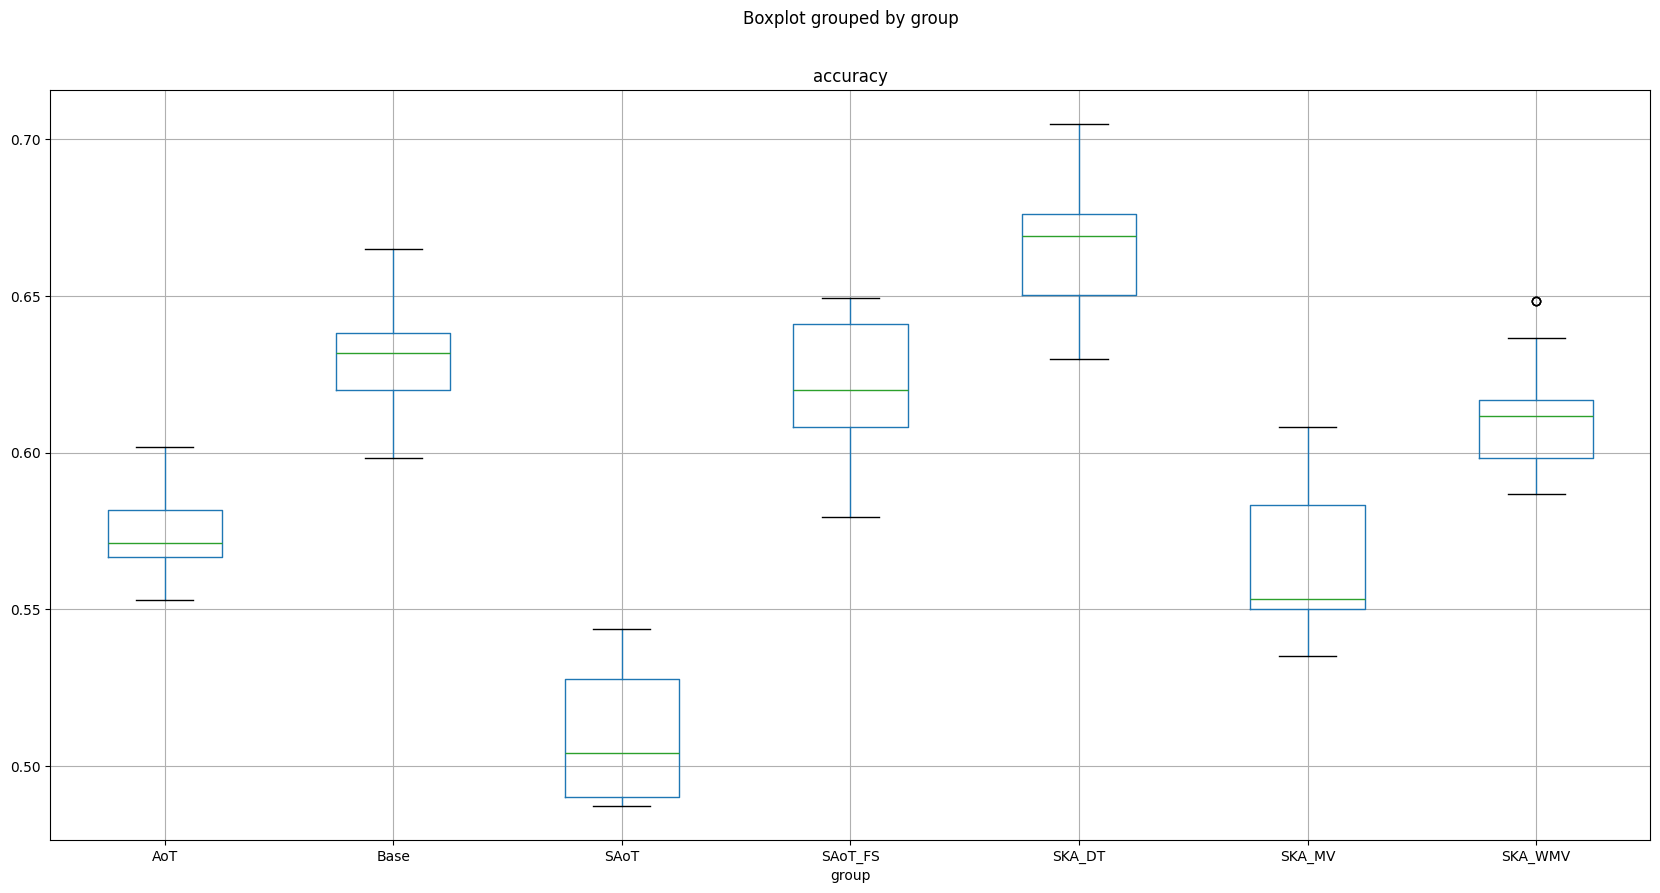

In [287]:
data_md[data_md["group"].isin(["Base","AoT","SAoT","SAoT_FS","SKA_DT","SKA_MV","SKA_WMV"])].boxplot(by ='group', column =['accuracy'], grid = True,figsize=(20,10))
plt.show()

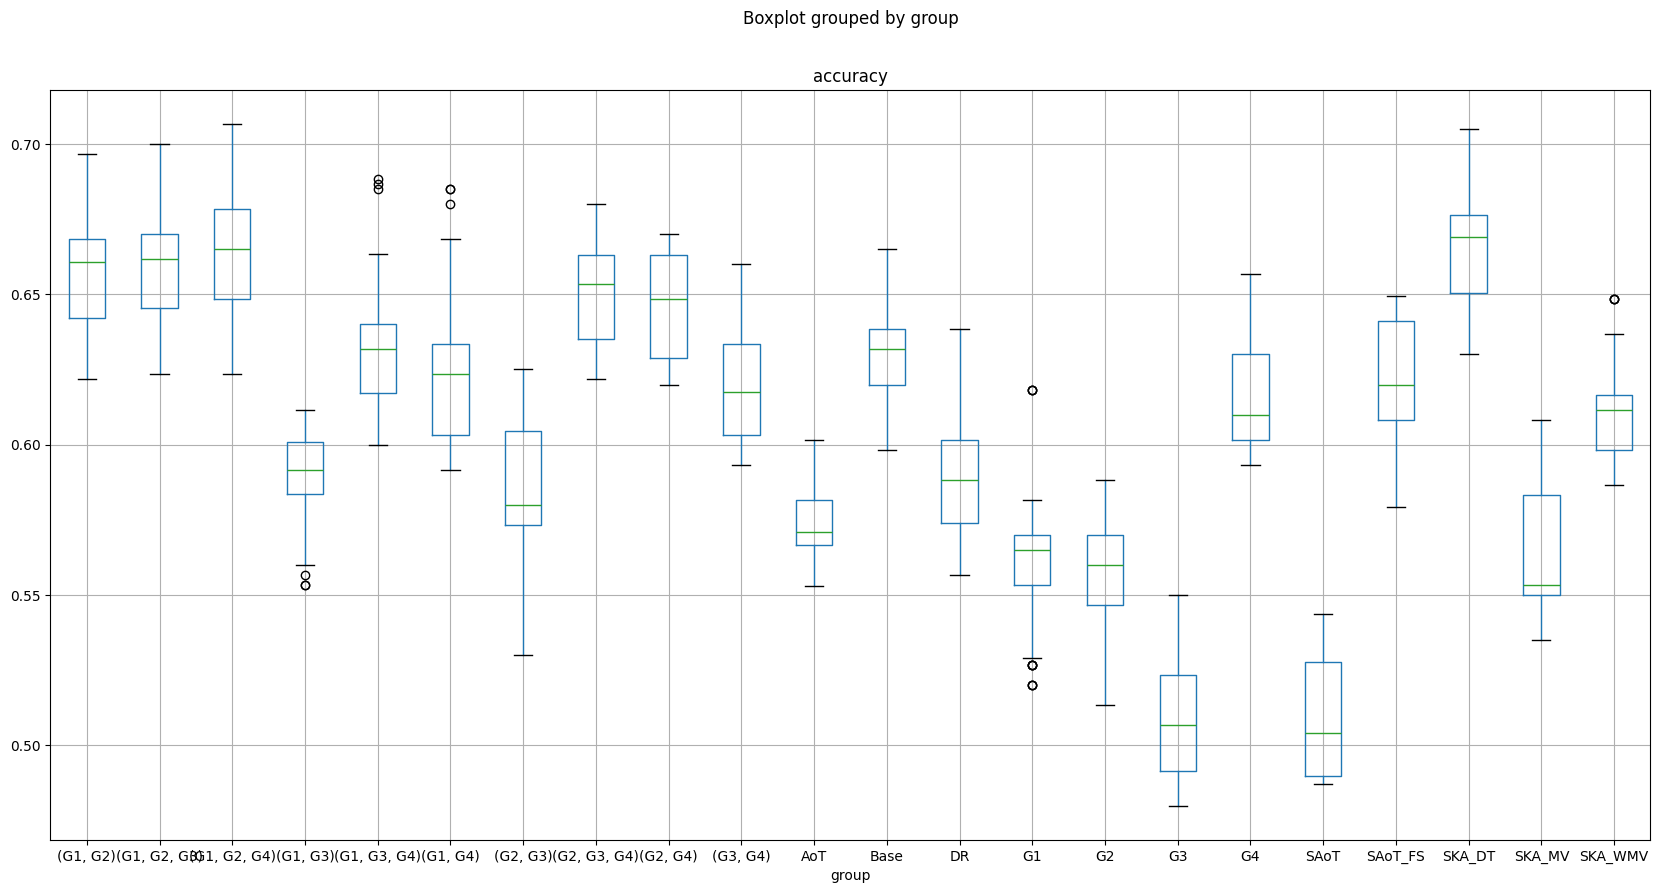

In [288]:
data_md.boxplot(by ='group', column =['accuracy'], grid = True,figsize=(20,10))
plt.show()

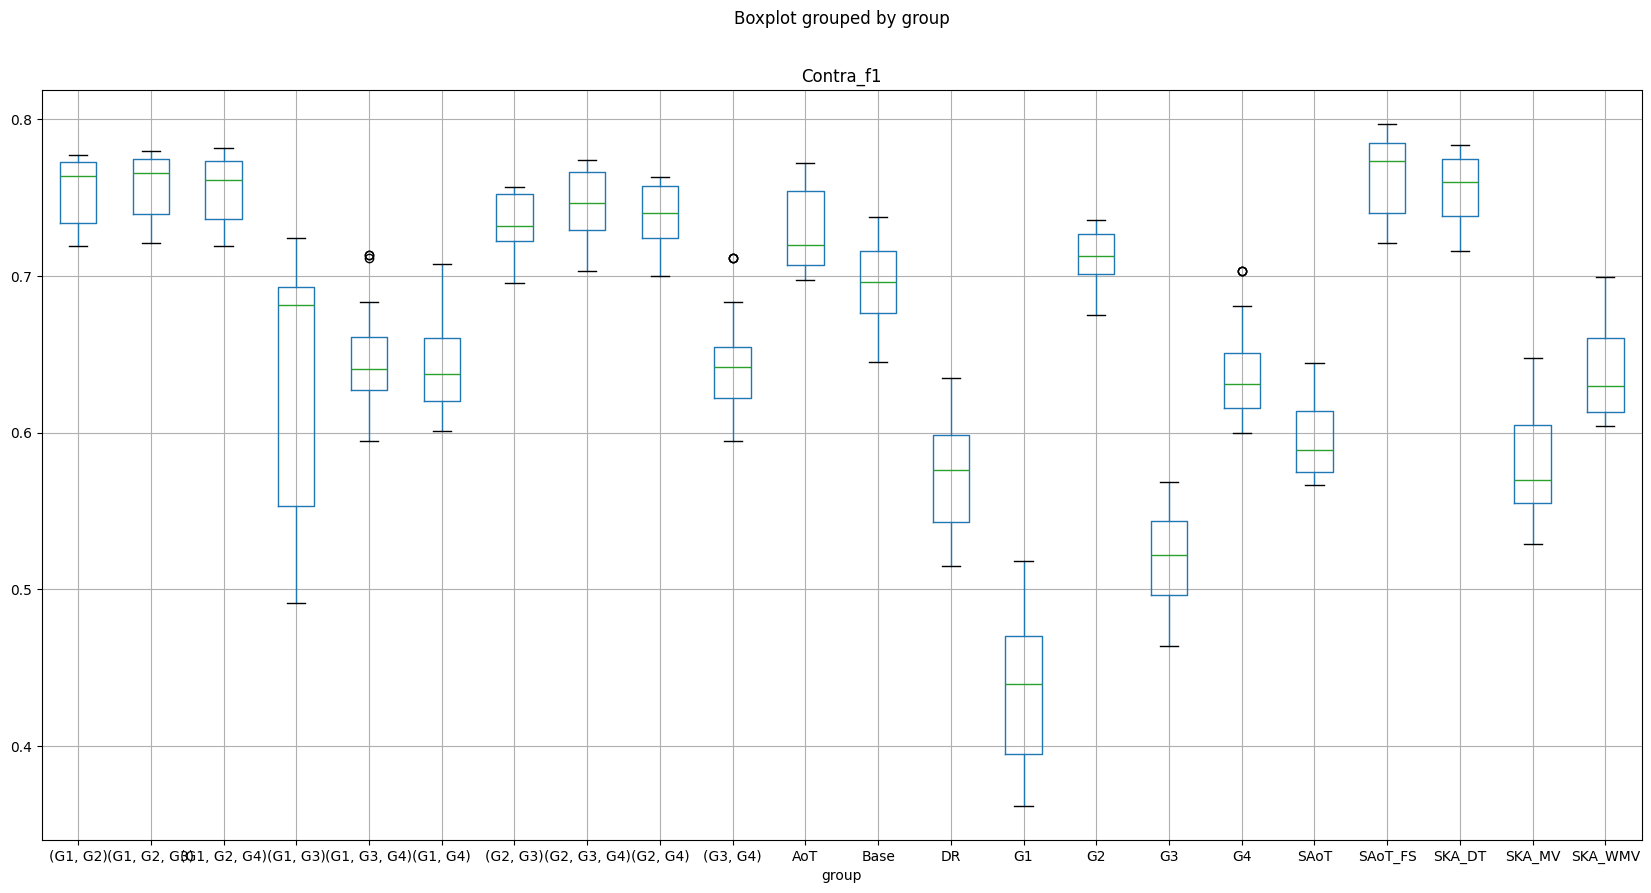

In [289]:
data_md.boxplot(by ='group', column =['Contra_f1'], grid = True,figsize=(20,10))
plt.show()

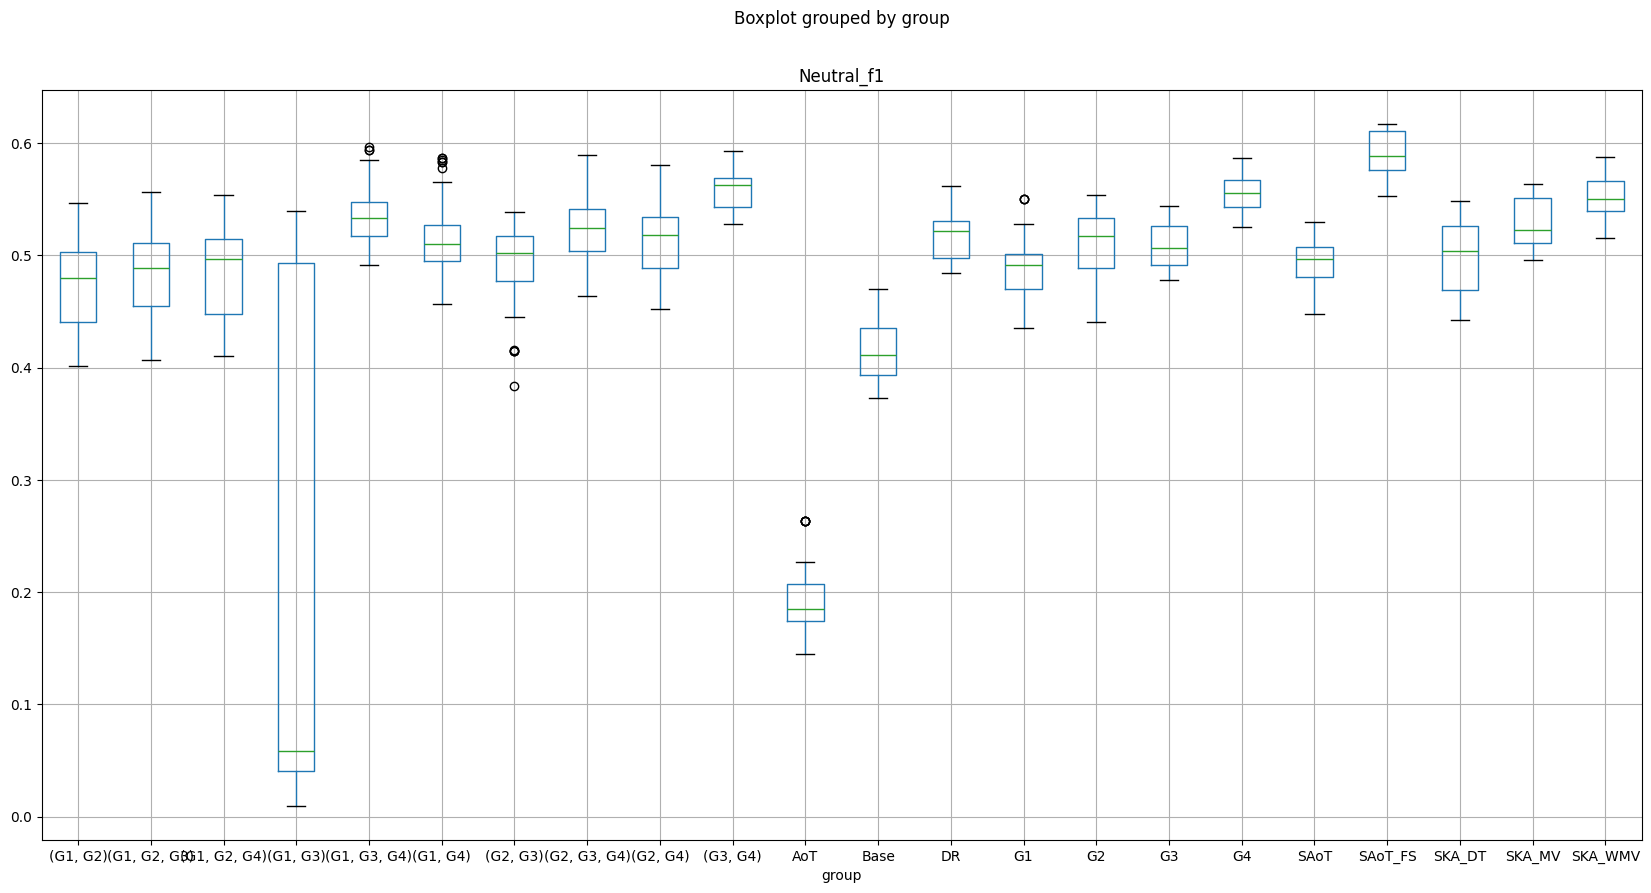

In [290]:
data_md.boxplot(by ='group', column =['Neutral_f1'], grid = True,figsize=(20,10))
plt.show()

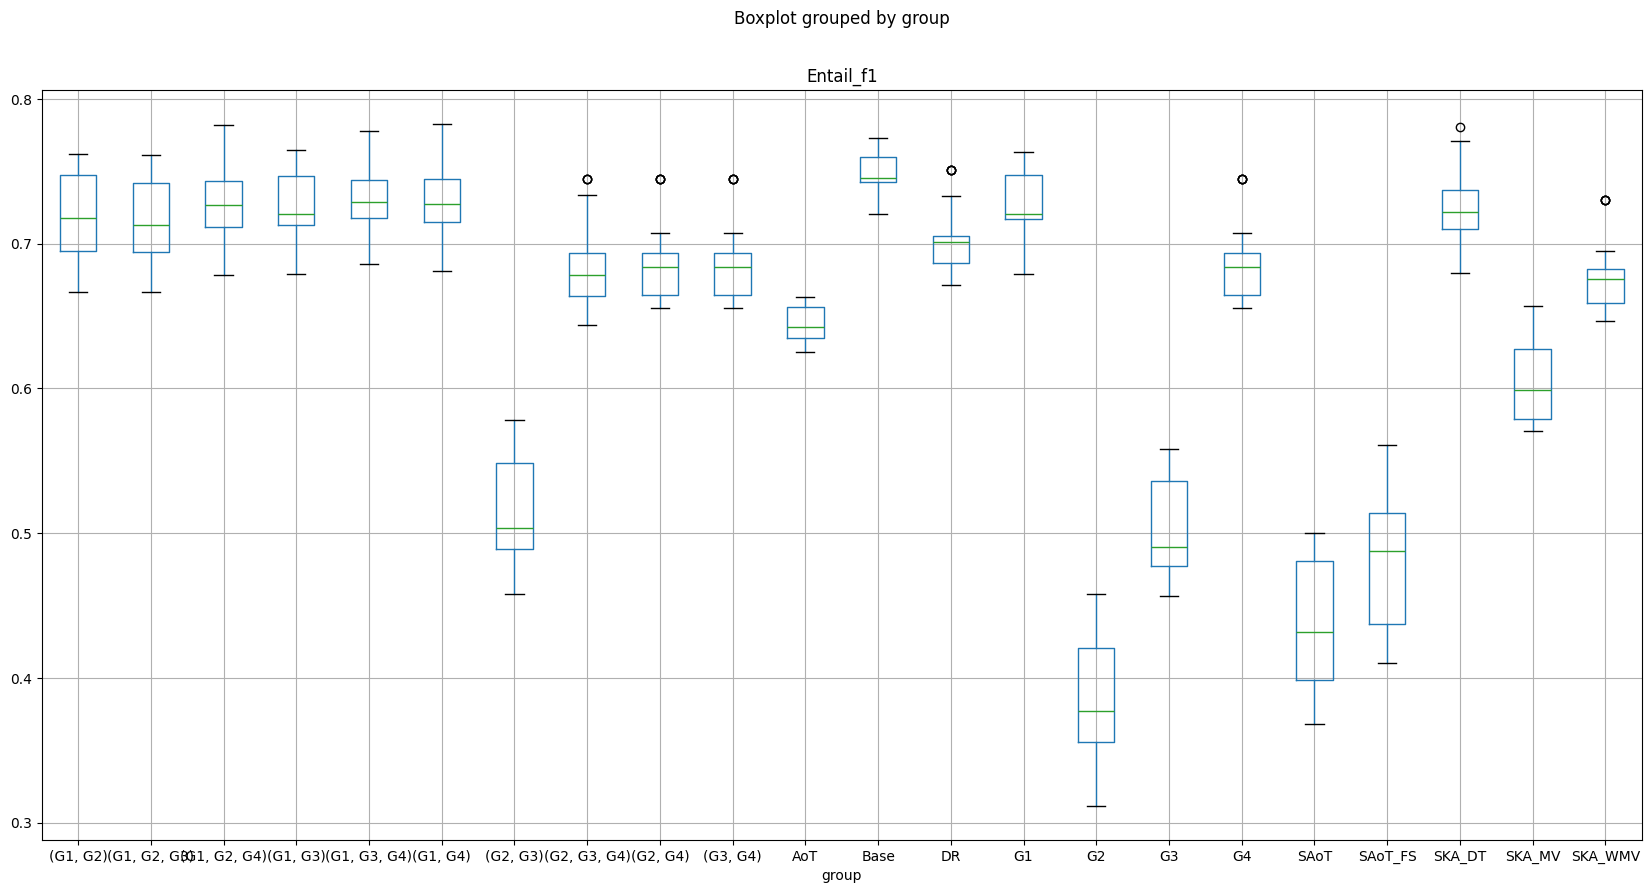

In [291]:
data_md.boxplot(by ='group', column =['Entail_f1'], grid = True,figsize=(20,10))
plt.show()